<a href="https://colab.research.google.com/github/sandeep-kumar-barada/Option-Pricing-Using-Modular-Neural-Network/blob/main/Project_MNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all necessery libraies
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from inspect import Traceback
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset,DataLoader
from torch.optim.lr_scheduler import StepLR


In [ ]:
# Data Preparation
drive.mount('/content/drive')
data=pd.read_csv('/content/drive/MyDrive/Modular Neural Network/R_modifieddata.csv')
data.drop(columns=['call_price'],inplace=True)
data.isna().sum()
data.dropna(inplace=True)
data.isna().sum()
data.columns
data.drop(columns=['QUOTE_UNIXTIME','QUOTE_READTIME','QUOTE_TIME_HOURS','EXPIRE_UNIX'],inplace=True)
data.shape
data
x=data.drop(columns=['option_price'])
y=data['option_price']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train.drop(columns=['QUOTE_DATE','EXPIRE_DATE'],inplace=True)
x_train
x_test.drop(columns=['QUOTE_DATE','EXPIRE_DATE','C_SIZE'],inplace=True)
x_train.drop(columns=['C_SIZE'],inplace=True)
x_train
# For Module 1
x_train.columns
train_dm1=x_train[['UNDERLYING_LAST','STRIKE']]
train_dm1['INTRINSIC_VALUE']= (train_dm1['UNDERLYING_LAST']-train_dm1['STRIKE']).clip(lower=0)
train_dm1['MONEYNESS']=train_dm1['STRIKE']/train_dm1['UNDERLYING_LAST']
train_dm1
train_dm1['LOG_MONEYNESS']=np.log(train_dm1['MONEYNESS'])
train_dm1['MONEYNESS*STRIKE_DISTANCE']=train_dm1['MONEYNESS']*data['STRIKE_DISTANCE']
train_dm1
x_train.columns
train_dm2=x_train[['DTE','C_IV','C_THETA','C_GAMMA']]
train_dm2['LOG_EXP']=np.log(train_dm2['DTE'])
train_dm2['DTE*C_IV']=train_dm2['DTE']*train_dm2['C_IV']
train_dm2['GAMMA/DTE']=train_dm2['C_GAMMA']/train_dm2['DTE']
train_dm2.replace([np.inf, -np.inf],np.nan ,inplace=True)
train_dm2.fillna(method='ffill',inplace=True)


# For Module 3
train_dm3=x_train[['C_DELTA']]
train_dm3[['DIVIDEND_YEILD','INTREST_RATE']]=0.02,0.05
train_dm3['DELTA*DIVIDEND_YEILD']=train_dm3['C_DELTA']*train_dm3['DIVIDEND_YEILD']
train_dm3

# For Module 4
train_dm4=x_train[['C_VOLUME']]
train_dm4['BID_ASK_SPREAD']=x_train['C_ASK']-x_train['C_BID']
train_dm4['VOLUME/BID_ASK_SPREAD']=train_dm4['C_VOLUME']/train_dm4['BID_ASK_SPREAD']
train_dm4.fillna(method='ffill',inplace=True)
train_dm4.isna().sum()

# For Module 5
train_dm5=x_train[['C_DELTA','C_GAMMA','C_THETA','C_THETA','C_RHO',]]
train_dm5['C_DELTA*C_VEGA']=train_dm5['C_DELTA']*data['C_VEGA']
train_dm5['C_GAMMA * C_THETA']=data['C_GAMMA']*data['C_THETA']
train_dm5['C_RH0*INTREST_RATE']=data['C_RHO']*train_dm3['INTREST_RATE']
train_dm5

# for module 6
train_dm6=x_train[['UNDERLYING_LAST','STRIKE','C_IV','tt']]
train_dm6[['DIVIDEND_YEILD','INTREST_RATE']]=0.02,0.05

# Scale the training data
scaler_m1 = StandardScaler()
train_dm1_scaled = scaler_m1.fit_transform(train_dm1)
train_dm1_scaled = pd.DataFrame(train_dm1_scaled, columns=train_dm1.columns)



scaler_m2 = StandardScaler()
train_dm2_scaled = scaler_m2.fit_transform(train_dm2)
train_dm2_scaled = pd.DataFrame(train_dm2_scaled, columns=train_dm2.columns)

scaler_m3 = StandardScaler()
train_dm3_scaled = scaler_m3.fit_transform(train_dm3)
train_dm3_scaled = pd.DataFrame(train_dm3_scaled, columns=train_dm3.columns)

scaler_m4 = StandardScaler()
train_dm4_scaled = scaler_m4.fit_transform(train_dm4)
train_dm4_scaled = pd.DataFrame(train_dm4_scaled, columns=train_dm4.columns)

scaler_m5 = StandardScaler()
train_dm5_scaled = scaler_m5.fit_transform(train_dm5)
train_dm5_scaled = pd.DataFrame(train_dm5_scaled, columns=train_dm5.columns)

scaler_m6 = StandardScaler()
train_dm6_scaled = scaler_m6.fit_transform(train_dm6)
train_dm6_scaled = pd.DataFrame(train_dm6_scaled, columns=train_dm6.columns)

# Convert training data to PyTorch tensors
device="cuda"
train_dm1 = torch.tensor(train_dm1_scaled.values, dtype=torch.float32).to(device)
train_dm2 = torch.tensor(train_dm2_scaled.values, dtype=torch.float32).to(device)
train_dm3 = torch.tensor(train_dm3_scaled.values, dtype=torch.float32).to(device)
train_dm4 = torch.tensor(train_dm4_scaled.values, dtype=torch.float32).to(device)
train_dm5 = torch.tensor(train_dm5_scaled.values, dtype=torch.float32).to(device)
train_dm6 = torch.tensor(train_dm6_scaled.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1) # Unsqueeze to make it (N, 1)

# Prepare test data similarly to train data
# For Module 1
x_test.columns
test_dm1 = x_test[['UNDERLYING_LAST','STRIKE']]
test_dm1['INTRINSIC_VALUE'] = (test_dm1['UNDERLYING_LAST']-test_dm1['STRIKE']).clip(lower=0)
test_dm1['MONEYNESS'] = test_dm1['STRIKE']/test_dm1['UNDERLYING_LAST']
test_dm1['LOG_MONEYNESS'] = np.log(test_dm1['MONEYNESS'])
test_dm1['MONEYNESS*STRIKE_DISTANCE'] = test_dm1['MONEYNESS'] * data.loc[x_test.index, 'STRIKE_DISTANCE']

# For Module 2
test_dm2 = x_test[['DTE','C_IV','C_THETA','C_GAMMA']]
test_dm2['LOG_EXP'] = np.log(test_dm2['DTE'])
test_dm2['DTE*C_IV'] = test_dm2['DTE'] * test_dm2['C_IV']
test_dm2['GAMMA/DTE'] = test_dm2['C_GAMMA'] / test_dm2['DTE']
test_dm2.replace([np.inf, -np.inf],np.nan ,inplace=True)
test_dm2.fillna(method='ffill',inplace=True)


# For Module 3
test_dm3 = x_test[['C_DELTA']]
test_dm3[['DIVIDEND_YEILD','INTREST_RATE']] = 0.02, 0.05
test_dm3['DELTA*DIVIDEND_YEILD'] = test_dm3['C_DELTA'] * test_dm3['DIVIDEND_YEILD']

# For Module 4
test_dm4 = x_test[['C_VOLUME']]
test_dm4['BID_ASK_SPREAD'] = x_test['C_ASK'] - x_test['C_BID']
test_dm4['VOLUME/BID_ASK_SPREAD'] = test_dm4['C_VOLUME'] / test_dm4['BID_ASK_SPREAD']
test_dm4.fillna(method='ffill',inplace=True)


# For Module 5
test_dm5 = x_test[['C_DELTA','C_GAMMA','C_THETA','C_THETA','C_RHO',]]
test_dm5['C_DELTA*C_VEGA'] = test_dm5['C_DELTA'] * data.loc[x_test.index, 'C_VEGA']
test_dm5['C_GAMMA * C_THETA'] = data.loc[x_test.index, 'C_GAMMA'] * data.loc[x_test.index, 'C_THETA']
test_dm5['C_RH0*INTREST_RATE'] = data.loc[x_test.index, 'C_RHO'] * test_dm3['INTREST_RATE']

# For module 6
test_dm6 = x_test[['UNDERLYING_LAST','STRIKE','C_IV','tt']]
test_dm6[['DIVIDEND_YEILD','INTREST_RATE']] = 0.02, 0.05


# Scale the test data using the scalers fitted on the training data
test_dm1_scaled = scaler_m1.transform(test_dm1)
test_dm1_scaled = pd.DataFrame(test_dm1_scaled, columns=test_dm1.columns)

test_dm2_scaled = scaler_m2.transform(test_dm2)
test_dm2_scaled = pd.DataFrame(test_dm2_scaled, columns=test_dm2.columns)

test_dm3_scaled = scaler_m3.transform(test_dm3)
test_dm3_scaled = pd.DataFrame(test_dm3_scaled, columns=test_dm3.columns)

test_dm4_scaled = scaler_m4.transform(test_dm4)
test_dm4_scaled = pd.DataFrame(test_dm4_scaled, columns=test_dm4.columns)

test_dm5_scaled = scaler_m5.transform(test_dm5)
test_dm5_scaled = pd.DataFrame(test_dm5_scaled, columns=test_dm5.columns)

test_dm6_scaled = scaler_m6.transform(test_dm6)
test_dm6_scaled = pd.DataFrame(test_dm6_scaled, columns=test_dm6.columns)

# Convert test data to PyTorch tensors
test_dm1 = torch.tensor(test_dm1_scaled.values, dtype=torch.float32).to(device)
test_dm2 = torch.tensor(test_dm2_scaled.values, dtype=torch.float32).to(device)
test_dm3 = torch.tensor(test_dm3_scaled.values, dtype=torch.float32).to(device)
test_dm4 = torch.tensor(test_dm4_scaled.values, dtype=torch.float32).to(device)
test_dm5 = torch.tensor(test_dm5_scaled.values, dtype=torch.float32).to(device)
test_dm6 = torch.tensor(test_dm6_scaled.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1) # Unsqueeze to make it (N, 1)


class module1Dataset(Dataset):
  def __init__(self,train_dm1,y_train):
    self.data=train_dm1
    self.label=y_train
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    return self.data[idx],self.label[idx]
class module2Dataset(Dataset):
  def __init__(self,train_dm2,y_train):
    self.data=train_dm2
    self.label=y_train
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    return self.data[idx],self.label[idx]
class module3Dataset(Dataset):
  def __init__(self,train_dm3,y_train):
    self.data=train_dm3
    self.label=y_train
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    return self.data[idx],self.label[idx]

class module4Dataset(Dataset):
  def __init__(self,train_dm4,y_train):
    self.data=train_dm4
    self.label=y_train
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    return self.data[idx],self.label[idx]
class module5Dataset(Dataset):
  def __init__(self,train_dm5,y_train):
    self.data=train_dm5
    self.label=y_train
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    return self.data[idx],self.label[idx]


class module6Dataset(Dataset):
  def __init__(self,train_dm6,y_train):
    self.data=train_dm6
    self.label=y_train
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    return self.data[idx],self.label[idx]

class CombinedDataset(Dataset):
    def __init__(self, data1, data2, data3, data4, data5,data6, labels):
        self.data1 = data1
        self.data2 = data2
        self.data3 = data3
        self.data4 = data4
        self.data5 = data5
        self.data6 = data6
        self.labels = labels
        # Ensure all data tensors have the same number of samples
        assert len(self.data1) == len(self.data2) == len(self.data3) == len(self.data4) == len(self.data5) == len(self.labels) == len(self.data6)

    def __len__(self):
        return len(self.data1)

    def __getitem__(self, idx):
        return self.data1[idx], self.data2[idx], self.data3[idx], self.data4[idx], self.data5[idx],self.data6[idx], self.labels[idx]

combined_train_dataset = CombinedDataset(train_dm1, train_dm2, train_dm3, train_dm4, train_dm5,train_dm6, y_train)
combined_train_loader = DataLoader(combined_train_dataset, batch_size=1024, shuffle=True)

combined_test_dataset = CombinedDataset(test_dm1, test_dm2, test_dm3, test_dm4, test_dm5,test_dm6, y_test)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=1024, shuffle=False)

input_size1=train_dm1.shape[1]
input_size2=train_dm2.shape[1]
input_size3=train_dm3.shape[1]
input_size4=train_dm4.shape[1]
input_size5=train_dm5.shape[1]
input_size6=train_dm6.shape[1]
print("Data preparation complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data preparation complete.


In [ ]:
# First Model: Instrinsic value and moneyness model
class IntrinscValueMoneynessModule(nn.Module):
  def __init__(self,input_size):
    super(IntrinscValueMoneynessModule, self).__init__()
    self.fc1=nn.Linear(input_size, 128)
    self.act1=nn.SiLU()
    self.out=nn.Linear(128,128)

  def forward(self,x):
    x = self.act1(self.fc1(x))
    return self.out(x)

# Second Model: Time Value Volatility Model
class TimeValueVolatilityModule(nn.Module):
  def __init__(self,input_size):
    super(TimeValueVolatilityModule, self).__init__()
    self.fc1=nn.Linear(input_size, 128)
    self.act1=nn.Tanh()
    self.out=nn.Linear(128,128)

  def forward(self,x):
    x = self.act1(self.fc1(x))
    return self.out(x)

# Third Moudle :Early Exercise and Dividend Module
class EarlyExerciseAndDividendModule(nn.Module):
  def __init__(self,input_size):
    super(EarlyExerciseAndDividendModule, self).__init__()
    self.fc1=nn.Linear(input_size,128)
    self.act1=nn.ReLU()
    self.out=nn.Linear(128,128)

  def forward(self,x):
    x = self.act1(self.fc1(x))
    return self.out(x)

# Forth Module: Liquidity and market Module
class LiquidityAndMarketModule(nn.Module):
  def __init__(self,input_size):
    super(LiquidityAndMarketModule, self).__init__()
    self.fc1=nn.Linear(input_size,128)
    self.act1=nn.ReLU()
    self.out=nn.Linear(128, 128)

  def forward(self,x):
    x = self.act1(self.fc1(x))
    return self.out(x)


# Fifth Module: Option greek Module
class OptionGreekModule(nn.Module):
  def __init__(self,input_size):
    super(OptionGreekModule, self).__init__()
    self.fc1=nn.Linear(input_size,128)
    self.act1=nn.ELU()
    self.out=nn.Linear(128,128)

  def forward(self,x):
    x = self.act1(self.fc1(x))
    return self.out(x)

class bsModule(nn.Module):
  def __init__(self,input_size):
    super(bsModule, self).__init__()
    self.fc1=nn.Linear(input_size,128)
    self.act1=nn.ReLU()
    self.out=nn.Linear(128,128)

  def forward(self,x):
    x = self.act1(self.fc1(x))
    return self.out(x)


# Final Module with whole class
class MNNOptionModule(nn.Module):
    def __init__(self, input_size1, input_size2, input_size3, input_size4, input_size5,input_size6):
        super(MNNOptionModule, self).__init__()
        self.module1 = IntrinscValueMoneynessModule(input_size1)
        self.module2 = TimeValueVolatilityModule(input_size2)
        self.module3 = EarlyExerciseAndDividendModule(input_size3)
        self.module4 = LiquidityAndMarketModule(input_size4)
        self.module5 = OptionGreekModule(input_size5)
        self.module6 = bsModule(input_size6)
        # Each module now outputs 128 features
        self.final_fc1 = nn.Linear(128 * 6, 128) # Combined features 128 * 5
        self.final_act1 = nn.ReLU()
        self.final_out = nn.Linear(128, 1)

    def forward(self, x1, x2, x3, x4, x5,x6):
        out1 = self.module1(x1)
        out2 = self.module2(x2)
        out3 = self.module3(x3)
        out4 = self.module4(x4)
        out5 = self.module5(x5)
        out6 = self.module6(x6)
        merged = torch.cat((out1, out2, out3, out4, out5,out6), dim=1)
        x = self.final_act1(self.final_fc1(merged))
        return self.final_out(x)


In [ ]:
model = MNNOptionModule(input_size1, input_size2, input_size3, input_size4, input_size5,input_size6).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

Epoch 1/100, Train Loss: 196.6405, Test Loss: 66.3774
Epoch 2/100, Train Loss: 117.0635, Test Loss: 485.2119
Epoch 3/100, Train Loss: 141.1916, Test Loss: 73.8888
Epoch 4/100, Train Loss: 91.0887, Test Loss: 113.7378
Epoch 5/100, Train Loss: 112.3027, Test Loss: 101.5045
Epoch 6/100, Train Loss: 121.5210, Test Loss: 111.0987
Epoch 7/100, Train Loss: 119.0353, Test Loss: 84.0416
Epoch 8/100, Train Loss: 268.7857, Test Loss: 126.3576
Epoch 9/100, Train Loss: 103.3327, Test Loss: 120.1997
Epoch 10/100, Train Loss: 126.6423, Test Loss: 235.9951
Epoch 11/100, Train Loss: 102.2146, Test Loss: 267.5266
Epoch 12/100, Train Loss: 123.8301, Test Loss: 135.8167
Epoch 13/100, Train Loss: 92.0448, Test Loss: 72.3743
Epoch 14/100, Train Loss: 101.3208, Test Loss: 93.0867
Epoch 15/100, Train Loss: 149.5161, Test Loss: 71.8436
Epoch 16/100, Train Loss: 77.7551, Test Loss: 82.6396
Epoch 17/100, Train Loss: 150.6702, Test Loss: 66.6070
Epoch 18/100, Train Loss: 74.6856, Test Loss: 49.7989
Epoch 19/100, 

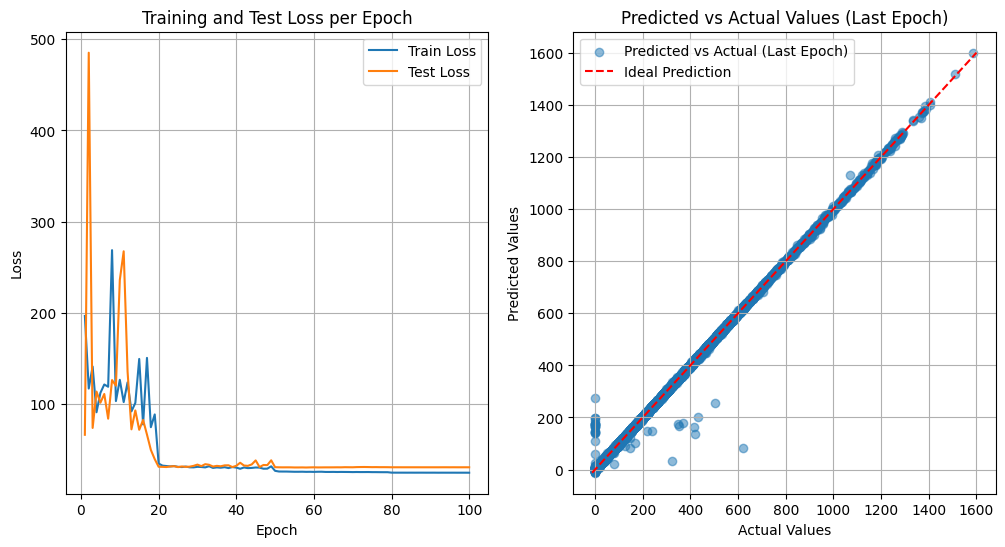

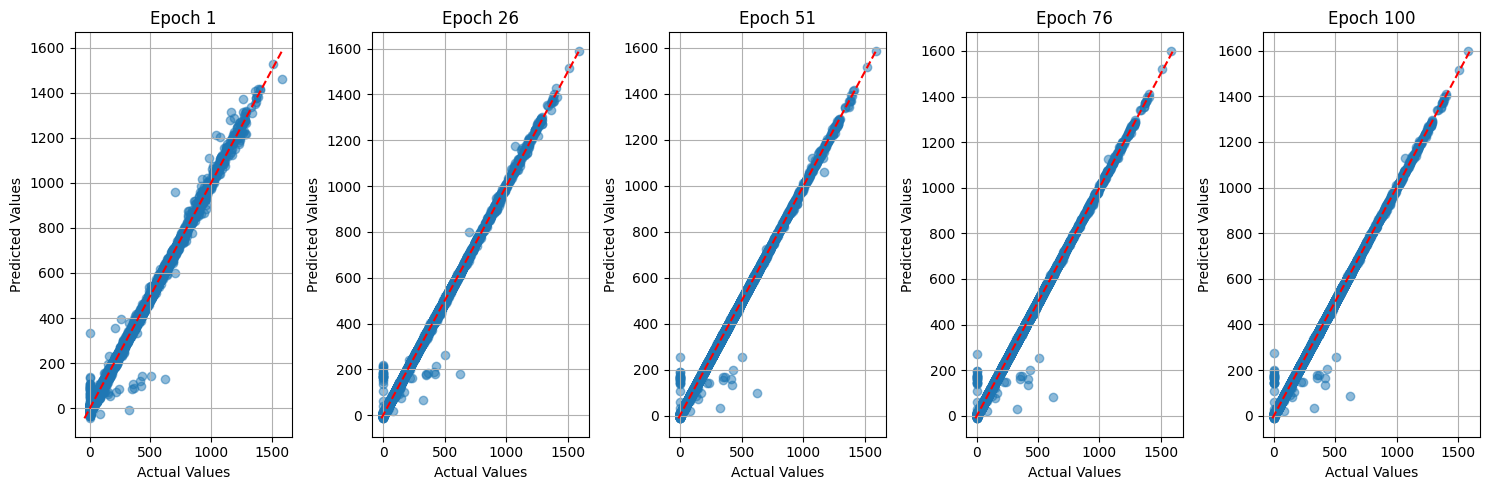

In [ ]:
# prompt: now give training of my module. additionally Draw predicted values and test values at each epoch. that shows me how my model converges

epochs = 100
train_losses = []
test_losses = []
predicted_values = []
test_values = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for data1, data2, data3, data4, data5, data6, labels in combined_train_loader:
        data1, data2, data3, data4, data5, data6, labels = data1.to(device), data2.to(device), data3.to(device), data4.to(device), data5.to(device), data6.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data1, data2, data3, data4, data5,data6)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * data1.size(0)

    train_loss = total_train_loss / len(combined_train_dataset)
    train_losses.append(train_loss)

    model.eval()
    total_test_loss = 0
    epoch_predicted = []
    epoch_actual = []
    with torch.no_grad():
        for data1, data2, data3, data4, data5, data6, labels in combined_test_loader:
            data1, data2, data3, data4, data5,data6, labels = data1.to(device), data2.to(device), data3.to(device), data4.to(device), data5.to(device), data6.to(device), labels.to(device)
            outputs = model(data1, data2, data3, data4, data5,data6)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item() * data1.size(0)
            epoch_predicted.extend(outputs.cpu().numpy())
            epoch_actual.extend(labels.cpu().numpy())

    test_loss = total_test_loss / len(combined_test_dataset)
    test_losses.append(test_loss)
    predicted_values.append(epoch_predicted)
    test_values.append(epoch_actual)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    scheduler.step()


# Plotting
epochs_list = range(1, epochs + 1)
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Train Loss')
plt.plot(epochs_list, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend()
plt.grid(True)

# Plot predicted vs test values at each epoch
plt.subplot(1, 2, 2)
# We'll plot the values from the last epoch for clarity, but you can loop through epochs if needed
plt.scatter(test_values[-1], predicted_values[-1], alpha=0.5, label='Predicted vs Actual (Last Epoch)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Last Epoch)')
# Add a diagonal line for perfect prediction
max_val = max(max(test_values[-1]), max(predicted_values[-1]))
min_val = min(min(test_values[-1]), min(predicted_values[-1]))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Prediction')
plt.legend()
plt.grid(True)


# To show convergence over epochs by plotting predicted vs test for a few representative epochs
plt.figure(figsize=(15, 5))
epochs_to_plot = [0, epochs // 4, epochs // 2, epochs * 3 // 4, epochs - 1] # Plot first, middle, and last few epochs

for i, epoch_idx in enumerate(epochs_to_plot):
    plt.subplot(1, len(epochs_to_plot), i + 1)
    plt.scatter(test_values[epoch_idx], predicted_values[epoch_idx], alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Epoch {epoch_idx + 1}')
    max_val = max(max(test_values[epoch_idx]), max(predicted_values[epoch_idx]))
    min_val = min(min(test_values[epoch_idx]), min(predicted_values[epoch_idx]))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    plt.grid(True)

plt.tight_layout()
plt.show()